### [Dimensionality Reduction - Random Projections](https://scikit-learn.org/stable/modules/random_projection.html)

- [random_projection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.random_projection) trades accuracy (as additional variance) for faster processing times & smaller model sizes. 

- It uses unstructured random matrices (RMs) to do this. Two variants:

    - [Gaussian RM](https://scikit-learn.org/stable/modules/random_projection.html#gaussian-random-matrix)
    - [Sparse RM](https://scikit-learn.org/stable/modules/random_projection.html#sparse-random-matrix)
    
- They are constrained to *preserve the pairwise distances between any two samples*.

- References:
    - [Experiments with random projection (Dasgupta, 2000)](https://cseweb.ucsd.edu/~dasgupta/papers/randomf.pdf)
    - [Random projections - image/text applications (Bingham, Mannila, 2001)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.24.5135&rep=rep1&type=pdf)_

### The [Johnson-Lindenstrauss lemma](https://en.wikipedia.org/wiki/Johnson%E2%80%93Lindenstrauss_lemma)

- The lemma: "a small set of points in a high-D space can be embedded into a low-D space with that distances between points are nearly preserved. The [map used for the embedding is at least Lipschitz](https://en.wikipedia.org/wiki/Lipschitz_continuity), and can even be taken to be an orthogonal projection.

- For a Lipschitz continuous function, there exists a double cone (white) whose origin can be moved along the graph so that the whole graph always stays outside the double cone: 

    ![Lipschitz continuous function](px/Lipschitz_Visualisierung.gif)

- [johnson_lindenstrauss_min_dim](https://scikit-learn.org/stable/modules/generated/sklearn.random_projection.johnson_lindenstrauss_min_dim.html#sklearn.random_projection.johnson_lindenstrauss_min_dim) estimates the minimal size of the random subspace needed to guarantee a bounded distortion introduced by the random projection - knowing only the #samples. 

In [2]:
# eps = max distortion rate per johnson-lindenstrauss lemma, [0..1]
from sklearn.random_projection import johnson_lindenstrauss_min_dim as JLMD

print(JLMD(n_samples=1e6,             eps=0.5))
print(JLMD(n_samples=1e6,             eps=[0.5, 0.1, 0.01]))
print(JLMD(n_samples=[1e4, 1e5, 1e6], eps=0.1))

663
[    663   11841 1112658]
[ 7894  9868 11841]


### [Gaussian RP](https://scikit-learn.org/stable/modules/generated/sklearn.random_projection.GaussianRandomProjection.html#sklearn.random_projection.GaussianRandomProjection)

- Reduces dimensionality by projecting original data on a randomly generated matrix with components drawn from $N(0, \frac{1}{n_{components}})$

In [24]:
import numpy as np
from sklearn import random_projection
X = np.random.rand(100, 10000)
print(X.shape)

X_new = random_projection.GaussianRandomProjection().fit_transform(X)
print(X_new.shape)

(100, 10000)
(100, 3947)


### [Sparse RP](https://scikit-learn.org/stable/modules/generated/sklearn.random_projection.SparseRandomProjection.html#sklearn.random_projection.SparseRandomProjection)

- Reduces dimensionality by projecting original data to a sparse random matrix.

- Sparse random matrices are an alternative to dense Gaussian random projection matrices. They guarantee *similar embedding quality* while being *much more memory efficient* and allowing *faster computation*.

- Given `s = 1/density`, the random matrix elements are drawn from $\begin{split}\left\{
\begin{array}{c c l}
-\sqrt{\frac{s}{n_{\text{components}}}} & & 1 / 2s\\
0 &\text{with probability}  & 1 - 1 / s \\
+\sqrt{\frac{s}{n_{\text{components}}}} & & 1 / 2s\\
\end{array}
\right.\end{split}$ where $n_components$ is the projected subspace size. Minimum non-zero element density is defined by $1 / \sqrt{n_{\text{features}}}$.

### [Example: JL embedding boundary with random projections](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_johnson_lindenstrauss_bound.html#sphx-glr-auto-examples-miscellaneous-plot-johnson-lindenstrauss-bound-py)

- The distortion introduced by a random projection p is asserted by the fact that p is defining an eps-embedding with good probability as defined by $(1 - eps) \|u - v\|^2 < \|p(u) - p(v)\|^2 < (1 + eps) \|u - v\|^2$

- $u$ and $v$ are any rows taken from a dataset of shape (n_samples, n_features).
- $p$ is a projection by a random Gaussian N(0,1) matrix of shape (n_components, n_features) (or a sparse Achlioptas matrix).

- The *minimum number of components* to guarantee the embedding is given by $n\_components \geq 4 log(n\_samples) / (eps^2 / 2 - eps^3 / 3)$.

- First plot: with increasing #n_samples, the minimal number of dimensions #n_components increases logarithmically to guarantee an eps-embedding.

In [4]:
import sys
from time import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.random_projection import johnson_lindenstrauss_min_dim as JLMD
from sklearn.random_projection import SparseRandomProjection as SRP
from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.datasets import load_digits
from sklearn.metrics.pairwise import euclidean_distances as ED
from sklearn.utils.fixes import parse_version

# `normed` is being deprecated in favor of `density` in histograms
if parse_version(matplotlib.__version__) >= parse_version('2.1'):
    density_param = {'density': True}
else:
    density_param = {'normed': True}

Text(0.5, 1.0, 'Johnson-Lindenstrauss bounds:\nn_samples vs n_components')

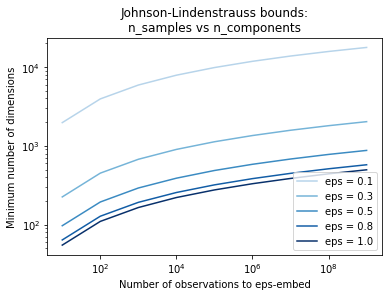

In [6]:
# range of admissible distortions
eps_range = np.linspace(0.1, 0.99, 5)
colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(eps_range)))

# range of number of samples (observation) to embed
n_samples_range = np.logspace(1, 9, 9)

plt.figure()
for eps, color in zip(eps_range, colors):
    min_n_components = JLMD(n_samples_range, eps=eps)
    plt.loglog(n_samples_range, min_n_components, color=color)

plt.legend(["eps = %0.1f" % eps for eps in eps_range], loc="lower right")
plt.xlabel("Number of observations to eps-embed")
plt.ylabel("Minimum number of dimensions")
plt.title("Johnson-Lindenstrauss bounds:\nn_samples vs n_components")

- Second plot: as admissable distortion `eps` increases, the min #dimensions (`n_components`) needed for a given `n_samples` drastically decreases.

Text(0.5, 1.0, 'Johnson-Lindenstrauss bounds:\nn_components vs eps')

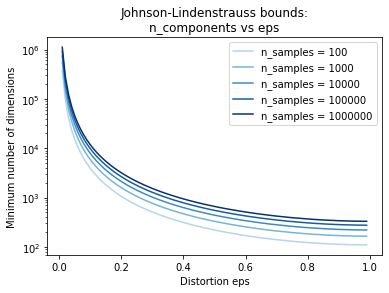

In [8]:
eps_range = np.linspace(0.01, 0.99, 100)

# range of number of samples (observation) to embed
n_samples_range = np.logspace(2, 6, 5)
colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(n_samples_range)))

plt.figure()
for n_samples, color in zip(n_samples_range, colors):
    min_n_components = JLMD(n_samples, eps=eps_range)
    plt.semilogy(eps_range, min_n_components, color=color)

plt.legend(["n_samples = %d" % n for n in n_samples_range], loc="upper right")
plt.xlabel("Distortion eps")
plt.ylabel("Minimum number of dimensions")
plt.title("Johnson-Lindenstrauss bounds:\nn_components vs eps")

### Empirical Validation

In [11]:
data = fetch_20newsgroups_vectorized().data[:500]

n_samples, n_features = data.shape
print("%d samples; dim %d"
      % (n_samples, n_features))

n_components_range = np.array([300, 1000, 10000])
dists = ED(data, squared=True).ravel()

# select only non-identical samples pairs
nonzero = dists != 0
dists = dists[nonzero]

500 samples; dim 130107


Projected 500 samples from 130107 to 300 in 0.236s
Random matrix with size: 1.298MB
Mean distances rate: 0.97 (0.18)
Projected 500 samples from 130107 to 1000 in 0.733s
Random matrix with size: 4.335MB
Mean distances rate: 0.93 (0.10)
Projected 500 samples from 130107 to 10000 in 7.479s
Random matrix with size: 43.273MB
Mean distances rate: 0.99 (0.03)


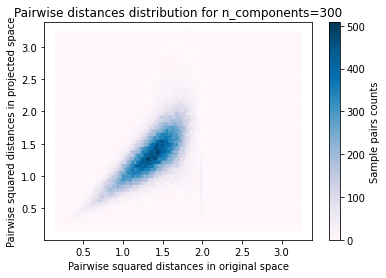

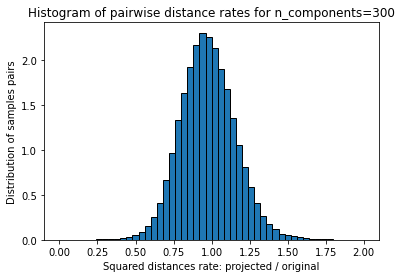

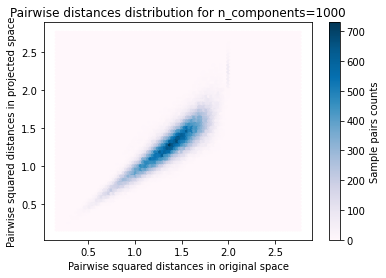

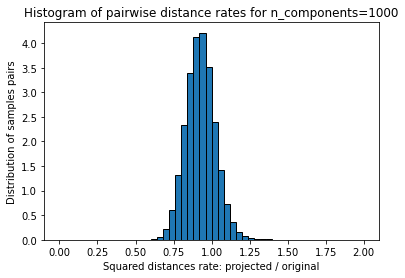

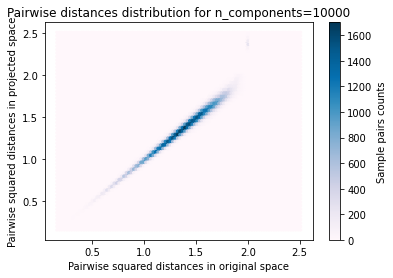

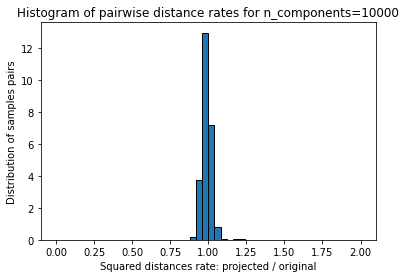

In [23]:
for n_components in n_components_range:
    t0 = time()
    rp = SRP(n_components=n_components)
    projected_data = rp.fit_transform(data)
    print("Projected %d samples from %d to %d in %0.3fs"
          % (n_samples, n_features, n_components, time() - t0))
    if hasattr(rp, 'components_'):
        n_bytes = rp.components_.data.nbytes
        n_bytes += rp.components_.indices.nbytes
        print("Random matrix with size: %0.3fMB" % (n_bytes / 1e6))

    projected_dists = ED(
        projected_data, squared=True).ravel()[nonzero]

    plt.figure()
    min_dist = min(projected_dists.min(), dists.min())
    max_dist = max(projected_dists.max(), dists.max())
    plt.hexbin(dists, projected_dists, gridsize=100, cmap=plt.cm.PuBu,
               extent=[min_dist, max_dist, min_dist, max_dist])
    plt.xlabel("Pairwise squared distances in original space")
    plt.ylabel("Pairwise squared distances in projected space")
    plt.title("Pairwise distances distribution for n_components=%d" %
              n_components)
    cb = plt.colorbar()
    cb.set_label('Sample pairs counts')

    rates = projected_dists / dists
    print("Mean distances rate: %0.2f (%0.2f)"
          % (np.mean(rates), np.std(rates)))

    plt.figure()
    plt.hist(rates, bins=50, range=(0., 2.), edgecolor='k', **density_param)
    plt.xlabel("Squared distances rate: projected / original")
    plt.ylabel("Distribution of samples pairs")
    plt.title("Histogram of pairwise distance rates for n_components=%d" %
              n_components)

    # TODO: compute the expected value of eps and add them to the previous plot
    # as vertical lines / region

- For low `n_components`: the distribution has many distorted pairs and a skewed distribution (due to the hard limit of zero ratio on the left as distances are always positives)

- For larger `n_components`: the distortion is controlled and the distances are well preserved by the random projection.

- According to the JL lemma, projecting 500 samples without too much distortion will require several thousand dimensions, irrespective of the number of features of the original dataset.

- Using random projections on the digits dataset (only 64 features)  does not make sense: it does not allow for dimensionality reduction in this case.

- On the twenty newsgroups on the other hand the dimensionality can be decreased from 56436 down to 10000 while reasonably preserving pairwise distances.